# Initialize Notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
from matplotlib import cm
import ROOT
import uproot
import os
import sys
import tqdm
import pandas as pd
import pickle as pkl
from sklearn.model_selection import train_test_split
import tensorflow as tf

%jsroot on
# %matplotlib qt
%matplotlib inline

Welcome to JupyROOT 6.30/02


In [2]:
sys.path.append('../python/')
from filterMethods import *
from hitAccuracyMethods import *
from statisticsMethods import *
from importMethods import *
from constants import *
import plotParameters

In [3]:
os.environ['PYDEVD_DISABLE_FILE_VALIDATION'] = '1'

# Load Data

In [4]:
# fileName = '../runs/event_2mu100MeVBackToBack_usedForTrackReconstruction.root'
# fileName = '../runs/calibration_2.42^3_10000gamma_1000events.root'
fileName = '../runs/calibration_2.42^3_1000gamma_1000events_0cmFOVL.root'
# fileName = '../build/calibration.root'
# fileName = '../build/event100.root'

histDir = '/photoSensor_hits_histograms'

print(get_histogram_names    (fileName, histDir))
print(get_histogram_titles   (fileName, histDir))
print(get_histogram_positions(fileName, histDir))
print(get_histogram_walls    (fileName, histDir))

['photoSensor_0;1', 'photoSensor_1;1', 'photoSensor_2;1', 'photoSensor_3;1', 'photoSensor_4;1', 'photoSensor_5;1', 'photoSensor_6;1', 'photoSensor_7;1', 'photoSensor_8;1', 'photoSensor_9;1', 'photoSensor_10;1', 'photoSensor_11;1', 'photoSensor_12;1', 'photoSensor_13;1', 'photoSensor_14;1', 'photoSensor_15;1', 'photoSensor_16;1', 'photoSensor_17;1', 'photoSensor_18;1', 'photoSensor_19;1', 'photoSensor_20;1', 'photoSensor_21;1', 'photoSensor_22;1', 'photoSensor_23;1', 'photoSensor_24;1', 'photoSensor_25;1', 'photoSensor_26;1', 'photoSensor_27;1', 'photoSensor_28;1', 'photoSensor_29;1', 'photoSensor_30;1', 'photoSensor_31;1', 'photoSensor_32;1', 'photoSensor_33;1', 'photoSensor_34;1', 'photoSensor_35;1', 'photoSensor_36;1', 'photoSensor_37;1', 'photoSensor_38;1', 'photoSensor_39;1', 'photoSensor_40;1', 'photoSensor_41;1', 'photoSensor_42;1', 'photoSensor_43;1', 'photoSensor_44;1', 'photoSensor_45;1', 'photoSensor_46;1', 'photoSensor_47;1', 'photoSensor_48;1', 'photoSensor_49;1', 'photoSen

In [5]:
treeName_photoSensor = 'photoSensor_hits;1'
treeName_lens        = 'lens_hits;1'
df_hits = pd.DataFrame(columns=['sensor_name', 'sensor_direction', 'sensor_position', 'relativePosition', 'relativePosition_binned', 'time'])
df_hits['sensor_name'                        ] = get_photosensor_hits_photosensor_ID              (fileName, treeName_photoSensor)
df_hits['sensor_direction'                   ] = get_photosensor_hits_photosensor_direction       (fileName, treeName_photoSensor)
df_hits['sensor_position'                    ] = get_photosensor_hits_photosensor_position        (fileName, treeName_photoSensor)
df_hits['relativePosition'                   ] = get_photosensor_hits_position_relative           (fileName, treeName_photoSensor)
df_hits['relativePosition_binned'            ] = get_photosensor_hits_position_relative_binned    (fileName, treeName_photoSensor, histDir)
df_hits['relativePosition_nBin'              ] = get_photosensor_hits_position_relative_nBin      (fileName, treeName_photoSensor, histDir)
df_hits['initialPosition'                    ] = get_photosensor_hits_position_initial            (fileName, treeName_photoSensor)
df_hits['time'                               ] = get_photosensor_hits_time                        (fileName, treeName_photoSensor)

df_hits['direction_relative'                 ] = get_photosensor_hits_direction_relative     (fileName, treeName_photoSensor)
df_hits['direction_relative_lens_0'          ] = get_photosensor_hits_direction_relative_lens(fileName, treeName_photoSensor, 0)
df_hits['position_relative_lens_0'           ] = get_photosensor_hits_position_relative_lens (fileName, treeName_photoSensor, 0)
df_hits['direction_relative_lens_1'          ] = get_photosensor_hits_direction_relative_lens(fileName, treeName_photoSensor, 1)
df_hits['position_relative_lens_1'           ] = get_photosensor_hits_position_relative_lens (fileName, treeName_photoSensor, 1)

df_hits = df_hits[df_hits['direction_relative_lens_0'] != (0, 0, 0)]
df_hits = df_hits[df_hits['direction_relative_lens_1'] != (0, 0, 0)]
df_hits = df_hits[df_hits['position_relative_lens_0' ] != (0, 0, 0)]
df_hits = df_hits[df_hits['position_relative_lens_1' ] != (0, 0, 0)]

df_hits['direction_relative_lens_0_theta'    ] = df_hits['direction_relative_lens_0'].apply(lambda x: np.arccos(x[2]/np.linalg.norm(x)))
df_hits['direction_relative_lens_0_phi'      ] = df_hits['direction_relative_lens_0'].apply(lambda x: np.arctan2(x[1], x[0]))
df_hits['position_relative_lens_0_phi'       ] = df_hits['position_relative_lens_0' ].apply(lambda x: np.arctan2(x[1], x[0]))
df_hits['direction_relative_lens_1_theta'    ] = df_hits['direction_relative_lens_1'].apply(lambda x: np.arccos(x[2]/np.linalg.norm(x)))
df_hits['direction_relative_lens_1_phi'      ] = df_hits['direction_relative_lens_1'].apply(lambda x: np.arctan2(x[1], x[0]))
df_hits['position_relative_lens_1_phi'       ] = df_hits['position_relative_lens_1' ].apply(lambda x: np.arctan2(x[1], x[0]))
df_hits['direction_relative_phi'             ] = df_hits['direction_relative'       ].apply(lambda x: np.arctan2(x[1], x[0]))
df_hits['position_relative_phi'              ] = df_hits['relativePosition'         ].apply(lambda x: np.arctan2(x[1], x[0]))

def boundAngle(angle):
    angle[angle > np.pi] -= 2*np.pi
    angle[angle < -np.pi] += 2*np.pi

    return angle

df_hits['theta_error'] = df_hits['direction_relative_lens_0_theta'] - df_hits['direction_relative_lens_1_theta']
df_hits['phi_error'  ] = df_hits['direction_relative_lens_0_phi'   ] - df_hits['direction_relative_lens_1_phi'  ]
df_hits['phi_error'  ] = boundAngle(df_hits['phi_error']).to_list()

/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_3571/557928634.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  angle[angle > np.pi] -= 2*np.pi
/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_3571/557928634.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  angle[angle < -np.pi] += 2*np.pi


In [6]:
treeName = 'primary;1'
df_primary = pd.DataFrame(columns=['position', 'time'])
df_primary['position'] = get_primary_position(fileName, treeName)
df_primary['time'    ] = get_primary_time    (fileName, treeName)

# Filter Hits

In [7]:
search_radius = 0
search_number = 0

df_hits = filter_hits(df_hits, radius=search_radius, number=search_number)

# Make Data

In [8]:
X = np.array(df_hits['relativePosition'].to_list()).reshape(-1, 3)[:,:2]
Y = np.array(df_hits['direction_relative'].to_list()).reshape(-1, 3)

print(X.shape, Y.shape)

(3767, 2) (3767, 3)


In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Make Model

In [42]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(2,)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(3, activation='linear')  # Output layer with linear activation
])
model.summary()
model.compile(optimizer='adam', loss='mean_squared_error')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 64)                192       
                                                                 
 dense_5 (Dense)             (None, 64)                4160      
                                                                 
 dense_6 (Dense)             (None, 3)                 195       
                                                                 
Total params: 4,547
Trainable params: 4,547
Non-trainable params: 0
_________________________________________________________________


In [43]:
history = model.fit(X_train, Y_train, epochs=1000, batch_size=32, validation_data=(X_test, Y_test), verbose=1)

Epoch 1/1000
95/95 [==============================] - 0s 1ms/step - loss: 5.1313 - val_loss: 0.0870
Epoch 2/1000
95/95 [==============================] - 0s 737us/step - loss: 0.0719 - val_loss: 0.0641
Epoch 3/1000
95/95 [==============================] - 0s 692us/step - loss: 0.0589 - val_loss: 0.0559
Epoch 4/1000
95/95 [==============================] - 0s 651us/step - loss: 0.0500 - val_loss: 0.0467
Epoch 5/1000
95/95 [==============================] - 0s 623us/step - loss: 0.0436 - val_loss: 0.0400
Epoch 6/1000
95/95 [==============================] - 0s 637us/step - loss: 0.0372 - val_loss: 0.0351
Epoch 7/1000
95/95 [==============================] - 0s 627us/step - loss: 0.0342 - val_loss: 0.0310
Epoch 8/1000
95/95 [==============================] - 0s 657us/step - loss: 0.0296 - val_loss: 0.0291
Epoch 9/1000
95/95 [==============================] - 0s 665us/step - loss: 0.0267 - val_loss: 0.0262
Epoch 10/1000
95/95 [==============================] - 0s 645us/step - loss: 0.0233 

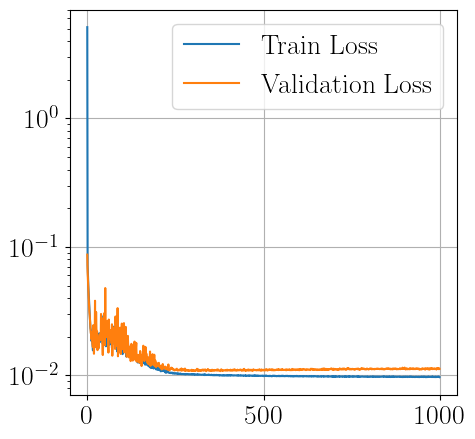

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.plot(history.history['loss']    , label='Train Loss')
ax.plot(history.history['val_loss'], label='Validation Loss')
ax.set_yscale('log')
ax.legend()
ax.grid()

plt.show()

24/24 [==============================] - 0s 347us/step


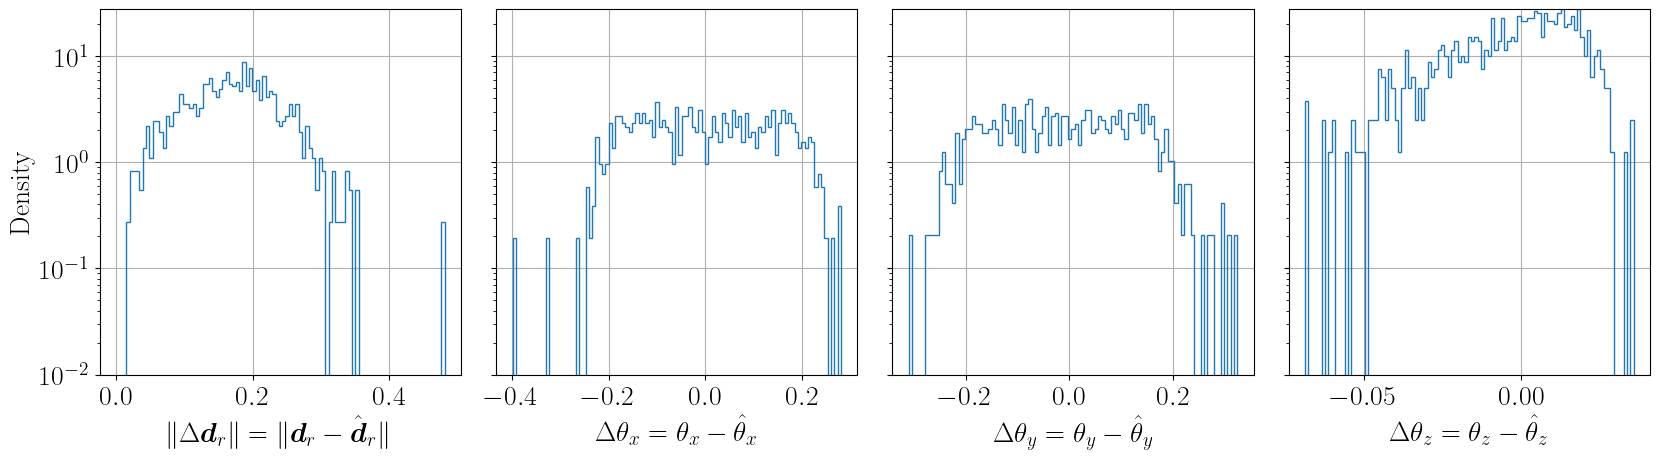

In [45]:
nBins = 100
cumulative = False
density = True
absolute = False
yScale = 'log'

Y_pred = model.predict(X_test)

Y_error = Y_test - Y_pred
if absolute:
    Y_error = np.abs(Y_error)
Y_mins = np.min(Y_error, axis=0)
Y_maxs = np.max(Y_error, axis=0)

bins_x = np.linspace(Y_mins[0], Y_maxs[0], nBins)
bins_y = np.linspace(Y_mins[1], Y_maxs[1], nBins)
bins_z = np.linspace(Y_mins[2], Y_maxs[2], nBins)
bins_a = np.linspace(0, np.max(np.linalg.norm(Y_error, axis=1)), nBins)

fig, ax = plt.subplots(1, 4, figsize=(17, 5))

hist_a = ax[0].hist(np.linalg.norm(Y_error, axis=1), bins=bins_a, histtype='step', cumulative=cumulative, density=density)
hist_x = ax[1].hist(Y_error[:,0]                   , bins=bins_x, histtype='step', cumulative=cumulative, density=density)
hist_y = ax[2].hist(Y_error[:,1]                   , bins=bins_y, histtype='step', cumulative=cumulative, density=density)
hist_z = ax[3].hist(Y_error[:,2]                   , bins=bins_z, histtype='step', cumulative=cumulative, density=density)

ax[0].set_xlabel(r'$\norm{\Delta \boldsymbol{d}_r}=\norm{\boldsymbol{d}_r-\hat{\boldsymbol{d}}_r}$')
ax[1].set_xlabel(r'$\Delta \theta_x=\theta_x-\hat{\theta}_x$' if not absolute else r'$|\Delta \theta_x|=|\theta_x-\hat{\theta}_x|$')
ax[2].set_xlabel(r'$\Delta \theta_y=\theta_y-\hat{\theta}_y$' if not absolute else r'$|\Delta \theta_y|=|\theta_y-\hat{\theta}_y|$')
ax[3].set_xlabel(r'$\Delta \theta_z=\theta_z-\hat{\theta}_z$' if not absolute else r'$|\Delta \theta_z|=|\theta_z-\hat{\theta}_z|$')

ax[0].set_ylabel('Density' if density else 'Counts')

yMin = np.min([np.min(hist_a[0]), np.min(hist_x[0]), np.min(hist_y[0]), np.min(hist_z[0])])
yMax = np.max([np.max(hist_a[0]), np.max(hist_x[0]), np.max(hist_y[0]), np.max(hist_z[0])])
if yScale == 'log':
    yMin = 1e-2
ax[0].set_ylim(yMin, yMax)
ax[1].set_ylim(yMin, yMax)
ax[2].set_ylim(yMin, yMax)
ax[3].set_ylim(yMin, yMax)

ax[0].set_yscale(yScale)
ax[1].set_yscale(yScale)
ax[2].set_yscale(yScale)
ax[3].set_yscale(yScale)

ax[1].set_yticklabels([])
ax[2].set_yticklabels([])
ax[3].set_yticklabels([])

ax[0].grid()
ax[1].grid()
ax[2].grid()
ax[3].grid()

fig.tight_layout(h_pad=0)
plt.show()

In [46]:
nBins = 50
lw = 2

density = True
cumulative = False
abs = True

error_theta = 
error_phi   = df_hits['direction_relative_lens_0_phi'  ] - df_hits['position_relative_phi' ]

if abs:
    error_theta = np.abs(error_theta)
    error_phi   = np.abs(error_phi  )

if abs:
    bins = np.linspace(0, np.pi, nBins)
else:
    bins = np.linspace(-np.pi, np.pi, nBins)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.hist(error_theta, bins=bins, histtype='step', lw=lw, 
        label=r'$\abs{\Delta\theta}=\abs{\theta-\hat{\theta}}$' if abs else r'$\Delta\theta=\theta-\hat{\theta}$',
        density=density, cumulative=cumulative)
ax.hist(error_phi  , bins=bins, histtype='step', lw=lw, 
        label=r'$\abs{\Delta\phi}=\abs{\phi-\hat{\phi}}$' if abs else r'$\Delta\phi=\phi-\hat{\phi}$',
        density=density, cumulative=cumulative)
ax.legend()
ax.set_xlabel('Error [rad]')
ax.set_ylabel('Density' if density else 'Counts')
# ax.set_yscale('log')
# ax.set_xlim(-np.pi, np.pi)
if abs:
    ax.set_xticks(np.linspace(0, np.pi, 3))
    ax.set_xticklabels([r'$0$', r'$\pi/2$', r'$\pi$'])
    ax.set_xlim(0, np.pi)
else:
    ax.set_xticks(np.linspace(-np.pi, np.pi, 5))
    ax.set_xticklabels([r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$'])
    ax.set_xlim(-np.pi, np.pi)

ax.grid()

plt.savefig('../figures/theta_phi_error.pdf', bbox_inches='tight')
plt.show()

SyntaxError: invalid syntax (1138471650.py, line 8)